# Pulseq spin-echo

a **spin-echo** Pulseq that runs a tiny **simulation + reconstruction** for a few TE values. It creates the following outputs:

- A parameterized spin-echo .seq file.
- Simulated recon images for different TE.
- A simple metric-vs-TE plot.

In [1]:

!pip -q install pypulseq>=1.4 numpy>=1.24 matplotlib>=3.7 pillow>=10
import os, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import pypulseq as pp

os.makedirs('seq', exist_ok=True)
os.makedirs('out', exist_ok=True)

## Generate a Spin-Echo Pulseq sequence
A compact educational sequence for demo (not scanner-optimized):
- **TE**: echo time (s)  
- **TR**: repetition time (s)  
- **flip**: excitation flip angle (deg)  
- **FOV**: field of view (m)  
- **Nx, Ny**: matrix size  
- **slice_thickness**: (m)

In [2]:
# === Parameters ===
TE = 60e-3            # seconds
TR = 2.5              # seconds
flip = 90.0           # degrees
FOV = 220e-3          # meters
Nx, Ny = 64, 64
slice_thickness = 5e-3
out_path = Path('seq/spin_echo.seq')


In [3]:
def _dur(obj, fallback=None):
    try:
        return pp.calc_duration(obj)
    except Exception:
        t = getattr(obj, 't', None)
        if t is not None and len(t):
            try:
                return float(t[-1])
            except Exception:
                pass
    return 0.0 if fallback is None else float(fallback)


In [4]:
def _unpack_rf_gz(pulse_tuple):
    # Accept 1, 2, or 3 returns: rf, (rf,gz), or (rf,gz,gz_reph)
    if not isinstance(pulse_tuple, (list, tuple)):
        return pulse_tuple, None, None
    rf = pulse_tuple[0]
    gz = pulse_tuple[1] if len(pulse_tuple) > 1 else None
    gz_reph = pulse_tuple[2] if len(pulse_tuple) > 2 else None
    return rf, gz, gz_reph

In [5]:
def _get(obj, name, default=0.0):
    return getattr(obj, name, default) if getattr(obj, name, None) is not None else default

In [6]:
def _seq_duration_seconds(seq):
    """
    get total sequence duration in seconds.
    Handles: property, method, method->tuple/list, etc.
    """
    d = getattr(seq, "duration", None)
    # If it's callable, call it
    if callable(d):
        d = d()
    # If it's a tuple/list/array, pick a sensible numeric (max is safest)
    if isinstance(d, (tuple, list)):
        nums = [float(x) for x in d if isinstance(x, (int, float))]
        if nums:
            return max(nums)  # conservative
    # Try to coerce to float
    try:
        return float(d)
    except Exception:
        return 0.0  # last resort


In [7]:
# Quantize any time to the system raster (default ~10 µs)
def _raster_time(system):
    # prefer grad raster; rf/adc are usually multiples of it
    return getattr(system, "grad_raster_time", 10e-6)

def _snap_to_raster(t, system):
    r = _raster_time(system)
    # nearest raster step, non-negative
    return max(0.0, float(np.round(t / r) * r))


In [8]:
def build_spin_echo_seq(TE=60e-3, TR=2.5, flip=90.0,
                        FOV=220e-3, Nx=64, Ny=64,
                        slice_thickness=5e-3, system=None):
    if system is None:
        system = pp.Opts(max_grad=28, grad_unit='mT/m',
                         max_slew=150, slew_unit='T/m/s',
                         rf_ringdown_time=20e-6, rf_dead_time=100e-6,
                         adc_dead_time=10e-6)

    seq = pp.Sequence(system)

    gamma = 42.576e6 * 2 * np.pi  # rad/s/T
    delta_k = 1/FOV
    k_width = Nx * delta_k

    rf90 = pp.make_sinc_pulse(flip_angle=np.deg2rad(flip),
                              duration=3e-3,
                              slice_thickness=slice_thickness,
                              apodization=0.4, time_bw_product=4,
                              system=system, return_gz=True)
    rf180 = pp.make_sinc_pulse(flip_angle=np.deg2rad(180),
                               duration=3e-3,
                               slice_thickness=slice_thickness,
                               apodization=0.4, time_bw_product=4,
                               system=system, return_gz=True)

    rf90_p, gz90, gz90_reph   = _unpack_rf_gz(rf90)
    rf180_p, gz180, gz180_reph = _unpack_rf_gz(rf180)

    readout_time = 3.2e-3
    gx = pp.make_trapezoid(channel='x', system=system,
                           amplitude=k_width/(gamma*readout_time),
                           flat_time=readout_time, rise_time=400e-6)
    adc = pp.make_adc(num_samples=Nx, duration=gx.flat_time,
                      delay=gx.rise_time, system=system)

    ky = (np.arange(Ny) - Ny/2) * delta_k
    gy_blips = [pp.make_trapezoid('y', area=ky_line/gamma, system=system, duration=800e-6)
                for ky_line in ky]

    gz_spoil = pp.make_trapezoid('z', system=system, area=6e-3, duration=1.2e-3)

    tau = TE/2

    seq.add_block(rf90_p, gz90)
    seq.add_block(gz_spoil)

    rf180_dur = _dur(rf180_p, 3e-3)
    delay1 = tau - (rf180_dur / 2.0)
    delay1_q = _snap_to_raster(delay1, system)
    if delay1_q > 0:
        seq.add_block(pp.make_delay(delay1_q))

    seq.add_block(rf180_p, gz180)

    adc_dur   = _dur(adc)
    adc_delay = _get(adc, 'delay', 0.0)
    gx_rise   = _get(gx,  'rise_time', 0.0)

    adc_center_offset = adc_dur/2.0 + adc_delay
    delay2 = tau - adc_center_offset - gx_rise
    delay2_q = _snap_to_raster(delay2, system)
    if delay2_q > 0:
        seq.add_block(pp.make_delay(delay2_q))


    for gy in gy_blips:
        seq.add_block(gy)
        seq.add_block(gx, adc)
        seq.add_block(gz_spoil)

    durt = _seq_duration_seconds(seq)
    tr_pad = float(TR) - durt
    tr_pad_q = _snap_to_raster(tr_pad, system)
    if tr_pad_q > 0:
        seq.add_block(pp.make_delay(tr_pad_q))

    return seq

seq = build_spin_echo_seq(TE=TE, TR=TR, flip=flip, FOV=FOV, Nx=Nx, Ny=Ny, slice_thickness=slice_thickness)
seq.write(str(out_path))

print('Wrote sequence to:', out_path)
print('Download from the file browser (left) or with:')
print('from google.colab import files; files.download("seq/spin_echo.seq")')

Wrote sequence to: seq/spin_echo.seq
Download from the file browser (left) or with:
from google.colab import files; files.download("seq/spin_echo.seq")


/tmp/ipython-input-4198579004.py:16: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf90 = pp.make_sinc_pulse(flip_angle=np.deg2rad(flip),
/tmp/ipython-input-4198579004.py:21: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf180 = pp.make_sinc_pulse(flip_angle=np.deg2rad(180),


## (Optional) Write multiple `.seq` files for a TE sweep
This cell writes multiple sequences with different TE values to `./seq/`.

In [9]:

TEs = [20e-3, 40e-3, 60e-3]
for te in TEs:
    seq_te = build_spin_echo_seq(TE=te, TR=TR, flip=flip, FOV=FOV, Nx=Nx, Ny=Ny, slice_thickness=slice_thickness)
    p = Path(f'seq/spin_echo_TE_{int(te*1e3)}ms.seq')
    seq_te.write(str(p))
    print('Wrote', p)


Wrote seq/spin_echo_TE_20ms.seq
Wrote seq/spin_echo_TE_40ms.seq
Wrote seq/spin_echo_TE_60ms.seq


/tmp/ipython-input-4198579004.py:16: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf90 = pp.make_sinc_pulse(flip_angle=np.deg2rad(flip),
/tmp/ipython-input-4198579004.py:21: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf180 = pp.make_sinc_pulse(flip_angle=np.deg2rad(180),


## Simulate & Reconstruct (toy)
A tiny phantom + exponential T2 decay to visualize TE contrast. Outputs 3 images and a metric-vs-TE plot in `./out/`.

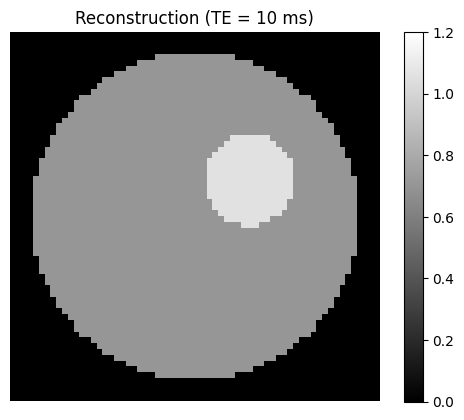

Saved out/single_tissue_recon_TE_10ms.png


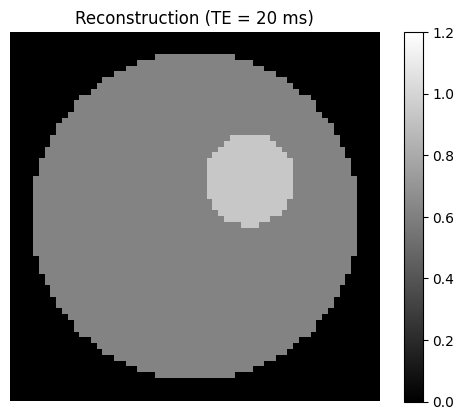

Saved out/single_tissue_recon_TE_20ms.png


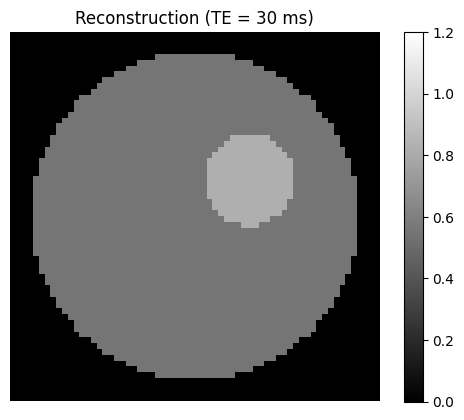

Saved out/single_tissue_recon_TE_30ms.png


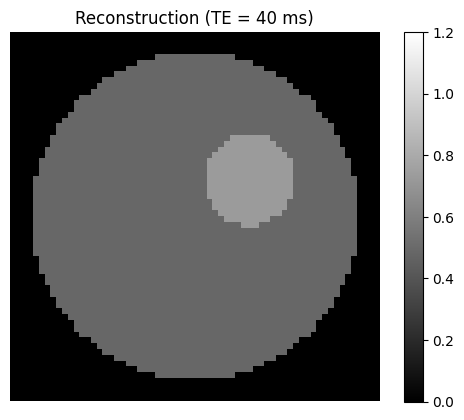

Saved out/single_tissue_recon_TE_40ms.png


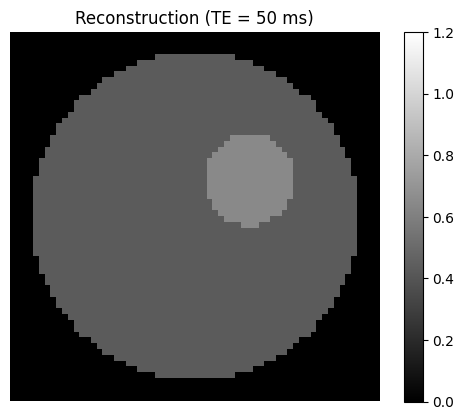

Saved out/single_tissue_recon_TE_50ms.png


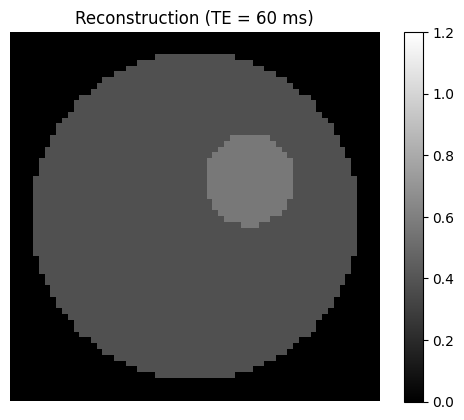

Saved out/single_tissue_recon_TE_60ms.png


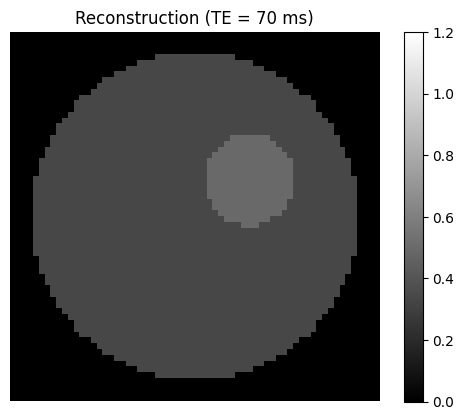

Saved out/single_tissue_recon_TE_70ms.png


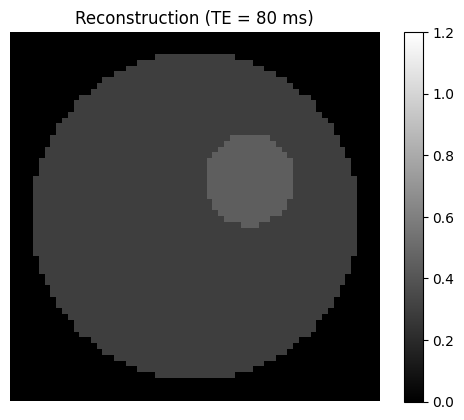

Saved out/single_tissue_recon_TE_80ms.png


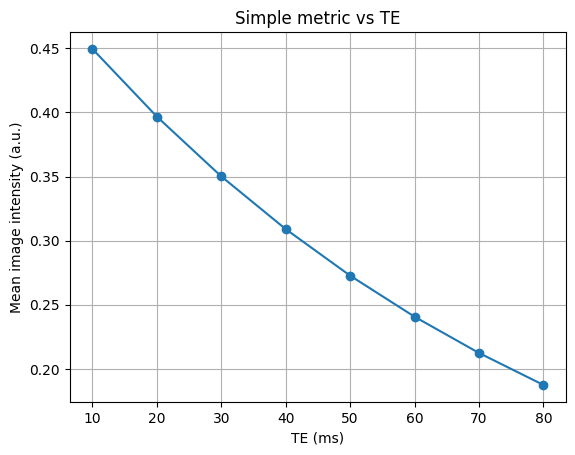

Saved out/metric_vs_TE.png


In [10]:
def shepp_logan(size=64):
    yy, xx = np.mgrid[-1:1:complex(0,size), -1:1:complex(0,size)]
    r1 = np.sqrt(xx**2 + yy**2)
    r2 = np.sqrt((xx-0.3)**2 + (yy+0.2)**2)
    img = (r1<0.9).astype(float)*0.8 + (r2<0.25).astype(float)*0.4
    return img

def fake_signal_decay(img, TE, T2=80e-3):
    return img * np.exp(-TE / T2)

def simulate_kspace(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))

def recon_image(kspace):
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace))))

TEs = [10e-3,20e-3,30e-3,40e-3,50e-3,60e-3,70e-3,80e-3]
size = 64
base = shepp_logan(size)

means = []
for TE_ in TEs:
    img_TE = fake_signal_decay(base, TE_)
    k = simulate_kspace(img_TE)
    img_rec = recon_image(k)
    means.append(img_rec.mean())
    plt.figure()
    vmin = 0.0
    vmax = base.max()            # or np.max(recon_image(simulate_kspace(base)))
    plt.imshow(img_rec, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(); plt.title(f'TE={int(TE_*1e3)} ms')
    #plt.imshow(img_rec, cmap='gray')
    plt.title(f'Reconstruction (TE = {int(TE_*1e3)} ms)')
    plt.axis('off')
    fn = f'out/single_tissue_recon_TE_{int(TE_*1e3)}ms.png'
    plt.savefig(fn, bbox_inches='tight', dpi=150)
    plt.show()
    print('Saved', fn)

plt.figure()
xms = np.array(TEs)*1e3
plt.plot(xms, means, marker='o')
plt.xlabel('TE (ms)')
plt.ylabel('Mean image intensity (a.u.)')
plt.title('Simple metric vs TE')
plt.grid(True)
plt.savefig('out/metric_vs_TE.png', bbox_inches='tight', dpi=150)
plt.show()
print('Saved out/metric_vs_TE.png')

In [11]:
from google.colab import files
files.download('seq/spin_echo.seq')
files.download('out/metric_vs_TE.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved out/two_tissue_recon_TE_10ms.png
Saved out/two_tissue_recon_TE_20ms.png
Saved out/two_tissue_recon_TE_30ms.png
Saved out/two_tissue_recon_TE_40ms.png
Saved out/two_tissue_recon_TE_50ms.png
Saved out/two_tissue_recon_TE_60ms.png
Saved out/two_tissue_recon_TE_70ms.png
Saved out/two_tissue_recon_TE_80ms.png


/tmp/ipython-input-3099763306.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.95,0.95])


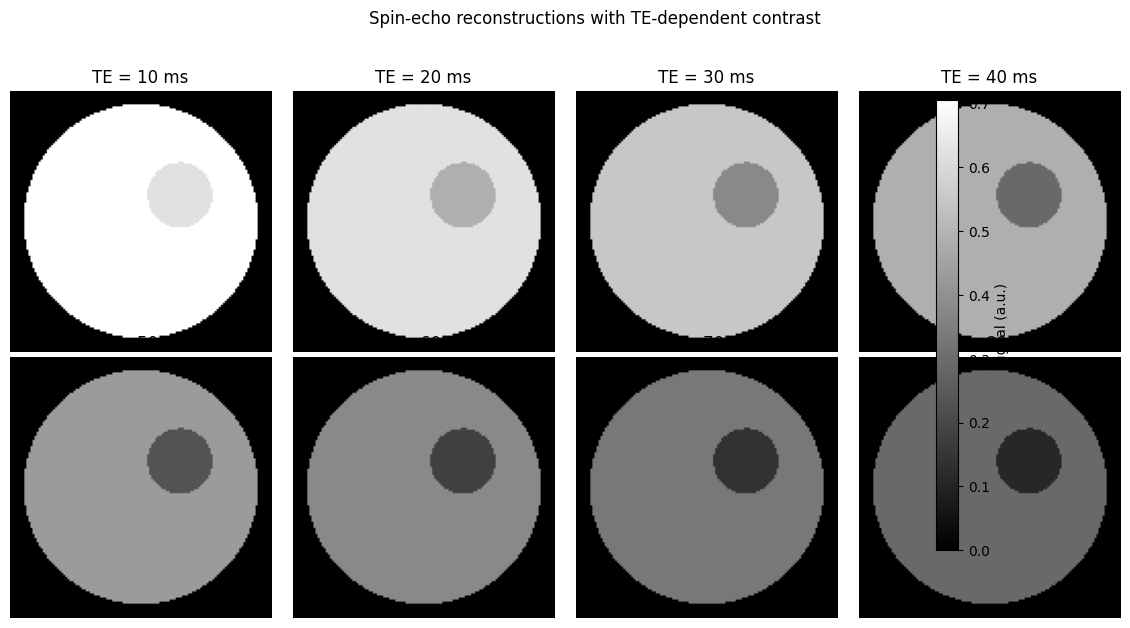

Saved out/recon_grid.png


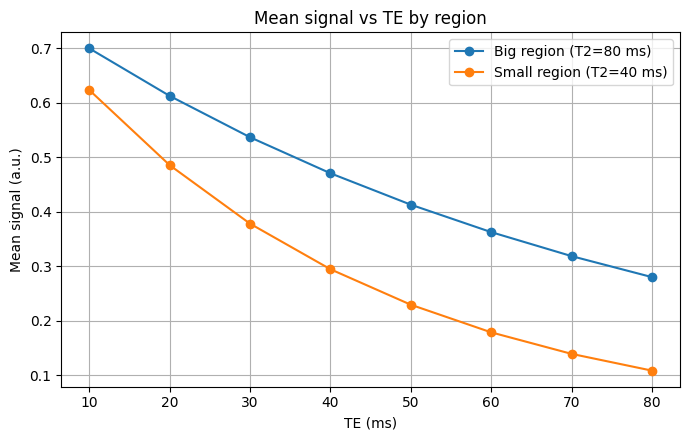

Saved out/metric_vs_TE.png
Estimated T2 (big region):     76.4 ms  (truth 80.0 ms)
Estimated T2 (small region):   40.0 ms  (truth 40.0 ms)


In [12]:
# --- Two-region T2 demo with saving outputs ---
import numpy as np
import matplotlib.pyplot as plt
import os

# make sure output folder exists
os.makedirs("out", exist_ok=True)

# ---------- Helpers ----------
def simulate_kspace(img):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))

def recon_image(kspace):
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace))))

def make_two_region_phantom(size=128, big_amp=0.8, small_amp=0.8,
                            small_center=(0.30, -0.20), big_r=0.90, small_r=0.25):
    yy, xx = np.mgrid[-1:1:complex(0, size), -1:1:complex(0, size)]
    r_big   = np.sqrt(xx**2 + yy**2)
    r_small = np.sqrt((xx - small_center[0])**2 + (yy - small_center[1])**2)

    mask_big   = r_big < big_r
    mask_small = r_small < small_r

    S0 = np.zeros((size, size), float)
    S0[mask_big]   = big_amp
    S0[mask_small] = small_amp

    return S0, {"big": mask_big, "small": mask_small}, (yy, xx)

def synth_image(S0map, TE, T2map):
    return S0map * np.exp(-TE / T2map)

# ---------- Configuration ----------
size = 128
TEs_ms = [10, 20, 30, 40, 50, 60, 70, 80]     # ms
TEs = np.array(TEs_ms, dtype=float) * 1e-3    # seconds

T2_big_ms   = 80.0
T2_small_ms = 40.0

S0, masks, _ = make_two_region_phantom(size=size, big_amp=0.8, small_amp=0.8)

T2map = np.full_like(S0, T2_big_ms * 1e-3, dtype=float)
T2map[masks["small"]] = T2_small_ms * 1e-3

# ---------- Simulation loop ----------
recons = []
means_big, means_small = [], []

for TEms, TE in zip(TEs_ms, TEs):
    img = synth_image(S0, TE, T2map)
    ksp = simulate_kspace(img)
    rec = recon_image(ksp)
    recons.append(rec)

    means_big.append(rec[masks["big"]].mean())
    means_small.append(rec[masks["small"]].mean())

    # save each reconstruction with fixed scale
    vmin, vmax = 0.0, rec.max()
    plt.figure()
    plt.imshow(rec, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title(f"Reconstruction (TE = {TEms} ms)")
    plt.axis("off")
    fn = f"out/two_tissue_recon_TE_{TEms}ms.png"
    plt.colorbar()
    plt.savefig(fn, bbox_inches="tight", dpi=150)
    plt.close()
    print("Saved", fn)

recons = np.array(recons)

# ---------- Show/save image grid ----------
cols = 4
rows = int(np.ceil(len(TEs) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 6.5))
axes = np.atleast_2d(axes)

vmin, vmax = 0.0, recons[0].max()
for i, (ax, rec, TEms) in enumerate(zip(axes.ravel(), recons, TEs_ms)):
    im = ax.imshow(rec, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f"TE = {TEms} ms")
    ax.axis('off')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), location="right", shrink=0.9, pad=0.02)
cbar.set_label('Signal (a.u.)')
plt.suptitle("Spin-echo reconstructions with TE-dependent contrast", y=0.98)
plt.tight_layout(rect=[0,0,0.95,0.95])
grid_fn = "out/recon_grid.png"
plt.savefig(grid_fn, bbox_inches="tight", dpi=150)
plt.show()
print("Saved", grid_fn)

# ---------- Plot/save region means vs TE ----------
plt.figure(figsize=(7,4.5))
plt.plot(TEs_ms, means_big,   marker='o', label=f'Big region (T2={T2_big_ms:.0f} ms)')
plt.plot(TEs_ms, means_small, marker='o', label=f'Small region (T2={T2_small_ms:.0f} ms)')
plt.xlabel("TE (ms)")
plt.ylabel("Mean signal (a.u.)")
plt.title("Mean signal vs TE by region")
plt.grid(True)
plt.legend()
plt.tight_layout()
curve_fn = "out/metric_vs_TE.png"
plt.savefig(curve_fn, bbox_inches="tight", dpi=150)
plt.show()
print("Saved", curve_fn)

# ---------- (Optional) T2 fit ----------
def fit_T2(TEs_s, y):
    y = np.asarray(y)
    mask = y > 0
    p = np.polyfit(TEs_s[mask], np.log(y[mask]), 1)
    T2_est = -1.0 / p[0]
    A_est = np.exp(p[1])
    return T2_est, A_est

T2b_est, Ab_est = fit_T2(TEs, means_big)
T2s_est, As_est = fit_T2(TEs, means_small)
print(f"Estimated T2 (big region):   {T2b_est*1e3:6.1f} ms  (truth {T2_big_ms:.1f} ms)")
print(f"Estimated T2 (small region): {T2s_est*1e3:6.1f} ms  (truth {T2_small_ms:.1f} ms)")


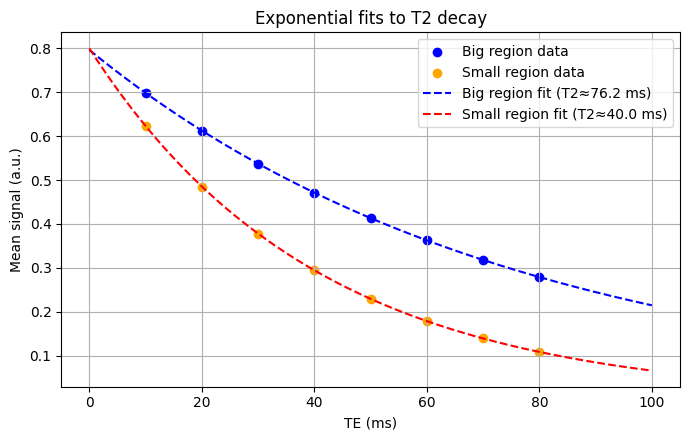

Saved out/metric_vs_TE_fit.png


In [13]:
# ---------- Plot with fitted curves ----------
from scipy.optimize import curve_fit

def exp_decay(TE, A, T2):
    return A * np.exp(-TE / T2)

# fit each region
popt_big, _ = curve_fit(exp_decay, np.array(TEs_ms, float), means_big, p0=(0.7, 80))
popt_small, _ = curve_fit(exp_decay, np.array(TEs_ms, float), means_small, p0=(0.6, 40))

plt.figure(figsize=(7,4.5))
plt.scatter(TEs_ms, means_big,   color='blue', label="Big region data")
plt.scatter(TEs_ms, means_small, color='orange', label="Small region data")

TE_fit = np.linspace(0, 100, 200)
plt.plot(TE_fit, exp_decay(TE_fit, *popt_big), 'b--',
         label=f'Big region fit (T2≈{popt_big[1]:.1f} ms)')
plt.plot(TE_fit, exp_decay(TE_fit, *popt_small), 'r--',
         label=f'Small region fit (T2≈{popt_small[1]:.1f} ms)')

plt.xlabel("TE (ms)")
plt.ylabel("Mean signal (a.u.)")
plt.title("Exponential fits to T2 decay")
plt.grid(True)
plt.legend()
plt.tight_layout()

fit_fn = "out/metric_vs_TE_fit.png"
plt.savefig(fit_fn, bbox_inches="tight", dpi=150)
plt.show()
print("Saved", fit_fn)
